## makemore: part 5

In [267]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from matplotlib.patches import Circle
import numpy as np
%matplotlib inline

In [268]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [269]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [270]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [271]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [272]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
    
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class PReLU:
  def __init__(self, a=0.1):
    self.a = torch.tensor([a])
      
  def __call__(self, x):
    self.out = torch.where(x >= 0, x, self.a * x)  
    return self.out

  def parameters(self):
    return [self.a]

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [273]:
torch.manual_seed(42); # seed rng for reproducibility

In [274]:
int(np.sqrt(vocab_size * block_size)) # Good heuristic for n_emb

14

In [276]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
a = 0.1 # PReLU init
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), PReLU(a), # Flatten to 16/2 = 8
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), PReLU(a),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), PReLU(a),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident
  # Using PRelU
  gain = np.sqrt(2 / (1 + a**2))
  for layer in model.layers[:-1]:
      if isinstance(layer, Linear):
          layer.weight *= gain

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

176878


In [277]:
# same optimization as last time
max_steps = 250000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for layer in model.layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  if i < 50000:
      lr = 0.1
  elif i < 100000:
      lr = 0.05
  elif i < 200000:
      lr = 0.01
  else:
      lr = 0.001
  # lr = 0.1 if i < 50000 elif i < 100000 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters if len(p) > 1])
    
  #if i == 1000: break

      0/ 250000: 3.2916
  10000/ 250000: 2.2084
  20000/ 250000: 2.0706
  30000/ 250000: 1.6526
  40000/ 250000: 1.9055
  50000/ 250000: 1.9197
  60000/ 250000: 1.8717
  70000/ 250000: 1.6143
  80000/ 250000: 1.6278
  90000/ 250000: 1.7201
 100000/ 250000: 1.4008
 110000/ 250000: 1.7878
 120000/ 250000: 2.0346
 130000/ 250000: 2.2836
 140000/ 250000: 1.9446
 150000/ 250000: 1.5047
 160000/ 250000: 1.7438
 170000/ 250000: 1.5742
 180000/ 250000: 1.5409
 190000/ 250000: 2.0828
 200000/ 250000: 2.0110
 210000/ 250000: 1.8713
 220000/ 250000: 1.9774
 230000/ 250000: 1.6325
 240000/ 250000: 1.8088


In [278]:
for layer in model.layers:
  if layer.out is not None:
      print(f"{layer.__class__.__name__}: {layer.out.shape}")

Embedding: torch.Size([32, 8, 24])
FlattenConsecutive: torch.Size([32, 4, 48])
Linear: torch.Size([32, 4, 200])
BatchNorm1d: torch.Size([32, 4, 200])
PReLU: torch.Size([32, 4, 200])
FlattenConsecutive: torch.Size([32, 2, 400])
Linear: torch.Size([32, 2, 200])
BatchNorm1d: torch.Size([32, 2, 200])
PReLU: torch.Size([32, 2, 200])
FlattenConsecutive: torch.Size([32, 400])
Linear: torch.Size([32, 200])
BatchNorm1d: torch.Size([32, 200])
PReLU: torch.Size([32, 200])
Linear: torch.Size([32, 27])


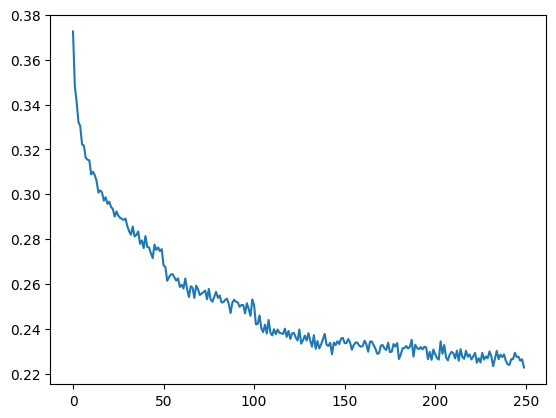

In [280]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

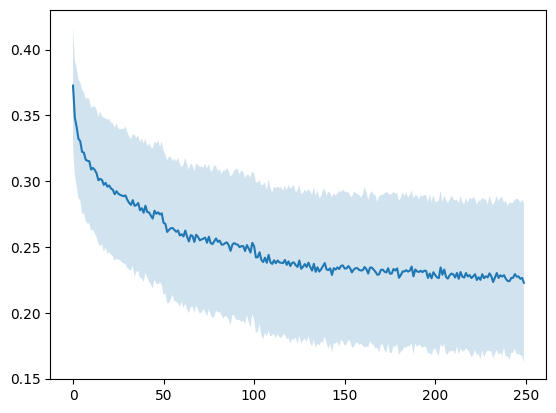

In [281]:
losses = torch.tensor(lossi).view(-1, 1000)
mean = losses.mean(1)
std = losses.std(1)

plt.plot(mean)
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)

### Visuals DEBUG

layer 4 (     PReLU): mean +0.44, std 0.54, saturated: 10.27%
layer 8 (     PReLU): mean +0.38, std 0.61, saturated: 14.53%
layer 12 (     PReLU): mean +0.35, std 0.60, saturated: 15.65%


Text(0.5, 1.0, 'activation distribution')

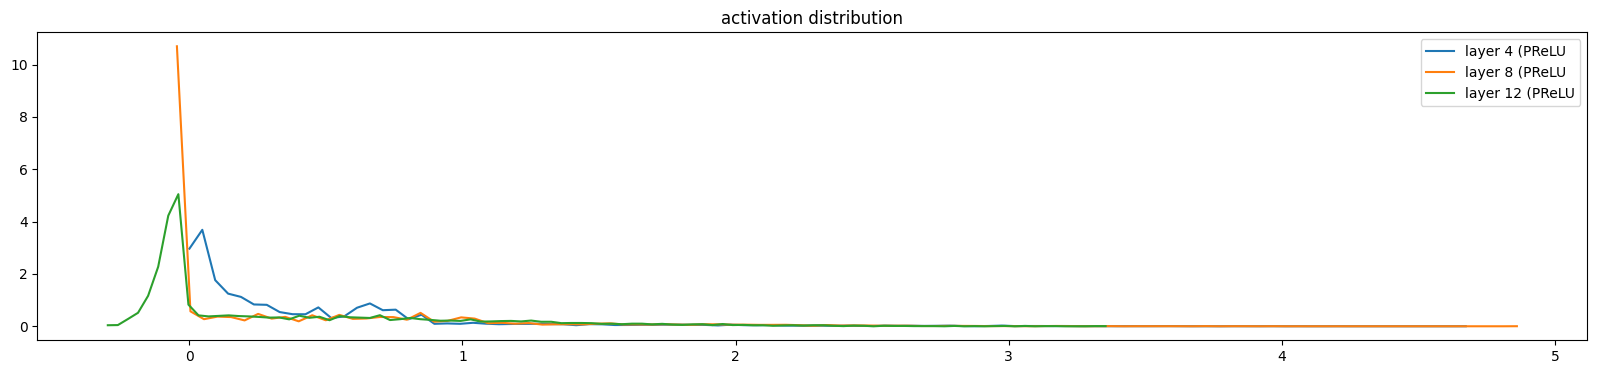

In [235]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh) or isinstance(layer, PReLU):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 4 (     PReLU): mean +0.000000, std 1.497986e-03
layer 8 (     PReLU): mean +0.000000, std 1.690811e-03
layer 12 (     PReLU): mean +0.000001, std 2.024822e-03


Text(0.5, 1.0, 'gradient distribution')

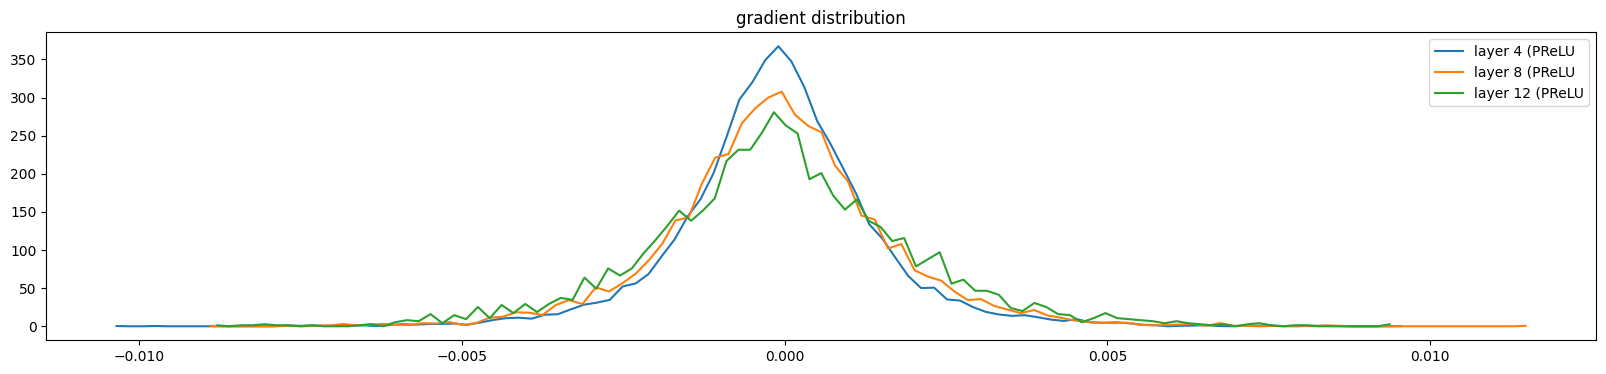

In [236]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh) or isinstance(layer, PReLU):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 20) | mean -0.000000 | std 6.452428e-03 | grad:data ratio 6.633569e-03
weight  (40, 128) | mean -0.000165 | std 8.822097e-03 | grad:data ratio 3.896816e-02
weight (256, 128) | mean +0.000078 | std 5.349585e-03 | grad:data ratio 5.957260e-02
weight (256, 128) | mean +0.000356 | std 4.549761e-03 | grad:data ratio 5.113409e-02
weight  (128, 27) | mean +0.000000 | std 1.796153e-02 | grad:data ratio 2.810448e-01


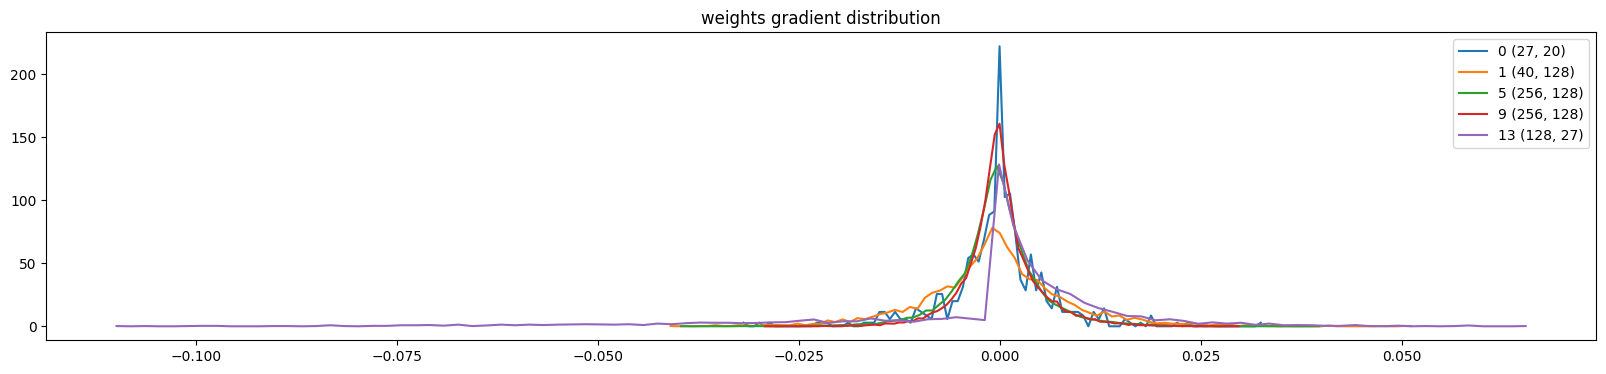

In [237]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Text(0.5, 1.0, 'log10(update/std) per parameter (non-scalars only)')

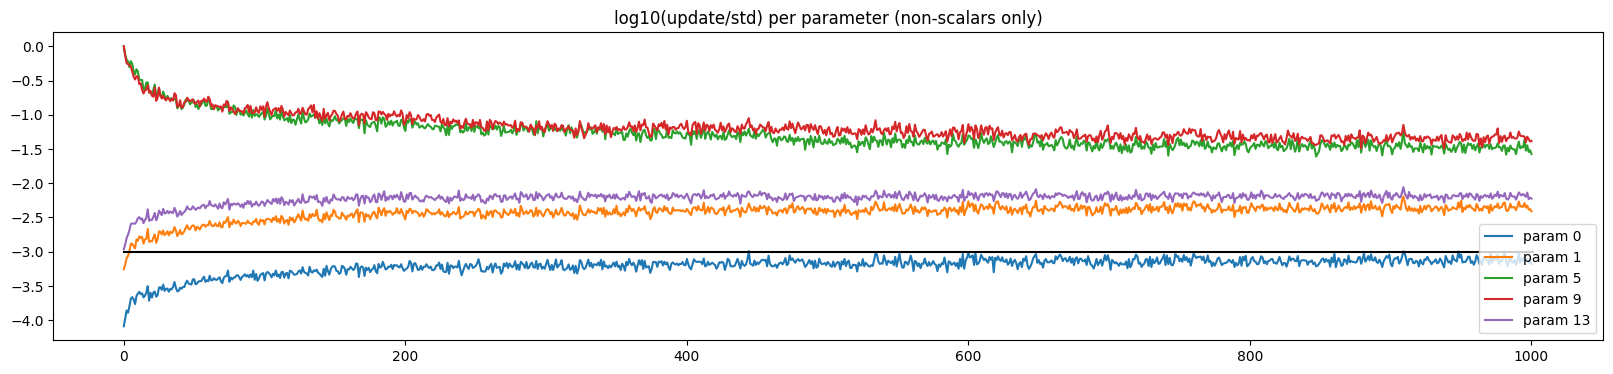

In [240]:
plt.figure(figsize=(20, 4))
legends = []
ud_col = 0  # index in ud[i] (i.e. across training steps)
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][ud_col] for j in range(len(ud))])
        legends.append(f'param {i}')
        ud_col += 1  # only increment when param was included in ud

plt.plot([0, len(ud)], [-3, -3], 'k')  # ideal log10 update ratio line
plt.legend(legends)
plt.title("log10(update/std) per parameter (non-scalars only)")

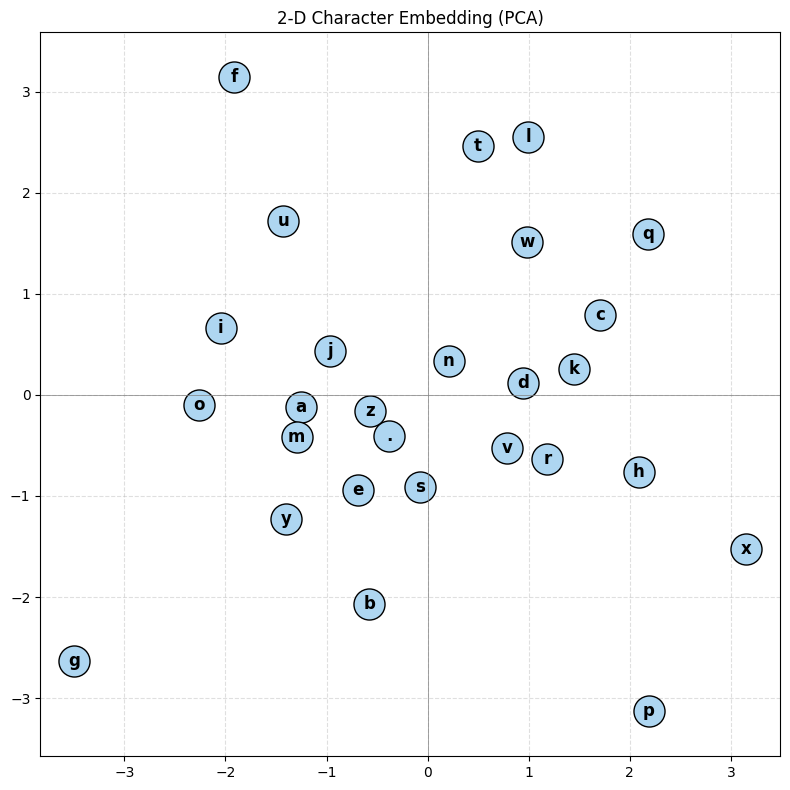

In [158]:
def plot_char_embeddings(model,
                         itos,
                         ax=None,
                         figsize=(8, 8),
                         facecolor="#AED6F1",
                         edgecolor="black",
                         fontsize=12,
                         marker_size=500,
                         pca=True):
    """
    Visualise a character embedding layer in 2-D.
    If the embedding has >2 dimensions and `pca` is True, the
    weights are projected to 2-D with PCA before plotting.
    """

    # 1. pull embedding matrix -> [vocab, D]
    emb = model.layers[0].weight.detach().cpu().numpy()
    D = emb.shape[1]

    # 2. optional PCA to 2-D
    if D > 2 and pca:
        # centred SVD PCA (no sklearn dependency)
        emb_c = emb - emb.mean(0, keepdims=True)
        U, S, Vt = np.linalg.svd(emb_c, full_matrices=False)
        emb_2d = emb_c @ Vt[:2].T          # [vocab, 2]
    elif D == 2:
        emb_2d = emb
    else:
        raise ValueError("Embedding dim < 2 – nothing to plot.")

    # 3. make axis if needed
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    # 4. scatter + labels
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1],
               s=marker_size, facecolors=facecolor,
               edgecolors=edgecolor, zorder=2)

    for idx, (x, y) in enumerate(emb_2d):
        ax.text(x, y, itos[idx],
                fontsize=fontsize, weight="bold",
                ha="center", va="center", zorder=3)

    # 5. cosmetics
    ax.set_title("2-D Character Embedding" + (" (PCA)" if D > 2 else ""))
    ax.axhline(0, lw=0.5, color="grey")
    ax.axvline(0, lw=0.5, color="grey")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_aspect("equal", adjustable="datalim")
    plt.tight_layout()

# usage ──────────────────────────────────────────────────────
plot_char_embeddings(model, itos)   # works for any embedding dim ≥2

### Evaluation

In [282]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [284]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6306984424591064
val 2.0301084518432617


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993

**My Results:**
- n_emb 20, n_hidden 128, 16 context (108k params): train 1.709, val 2.0157
- PReLU, n_emb 14, n_hidden 128, 8 context (73k params): train 1.709, val 2.000

In [285]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

aquill.
alannah.
emmet.
montez.
patey.
daron.
mikiya.
brodin.
fainy.
amarrion.
gulta.
carsette.
deklan.
maiseef.
morey.
wailen.
jasaiah.
ireland.
summit.
javon.


### Next time:
Why convolutions? Brief preview/hint

In [15]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [16]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [17]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [18]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space